# Прогнозирование вероятности оттока клиентов сети фитнес-центров «Культурист-датасаентист»

Сеть фитнес-центров «Культурист-датасаентист» разрабатывает стратегию взаимодействия с пользователями на основе аналитических данных. Для борьбы с оттоком клиентов, отдел по работе с клиентами «Культуриста-датасаентиста» перевёл в электронный вид множество анкет пользователей. Задача данного исследования заключается в проведении анализа и подготовки плана действий по удержанию клиентов. А именно:
   - формирование прогноза вероятности оттока (на уровне следующего месяца) для каждого клиента;
   - формирование типичных портретов пользователей;
   - выделение нескольких наиболее ярких групп и описание их основных свойств;
   - анализ основных признаков, наиболее сильно влияющие на отток;
   - формулировка основных выводов;
   - пазработка рекомендаций по повышению качества работы с клиентами.

## Загрузка данных и изучение общей информации

### Загрузка библиотек

Мой основной инструмент — `pandas`. Я подключаю эту библиотеку. Также подключаю библиотеки, `seaborn`, `re`, `numpy` и `matplotlib` - они понадобятся для моих исследований.

Дополнительно отключу предупреждения (библиотека `warnings`).

In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import KMeans
import itertools

import warnings as wg              

#wg.filterwarnings('ignore')

### Загрузка и описание данных

Осуществляю чтение файла данных о заведениях общественного питания Москвы `gym_churn.csv` из папки `/datasets` и сохраняю его в переменной `data`. Вывожу на экран первые пять строк таблицы и общую информацию о полученном датафрейме.

In [3]:
try:
    data = pd.read_csv('/Users/a4128/Documents/My_projects/10_fitnes/gym_churn.csv') # локальный путь
except:
    data = pd.read_csv('/datasets/gym_churn.csv') # серверный путь

display(data.head())
print()
data.info()

,gender,Near_Location,Partner,Promo_friends,Phone,Contract_period,Group_visits,Age,Avg_additional_charges_total,Month_to_end_contract,Lifetime,Avg_class_frequency_total,Avg_class_frequency_current_month,Churn
0,1,1,1,1,0,6,1,29,14.227470,5.0,3,0.020398,0.000000,0
1,0,1,0,0,1,12,1,31,113.202938,12.0,7,1.922936,1.910244,0
2,0,1,1,0,1,1,0,28,129.448479,1.0,2,1.859098,1.736502,0
3,0,1,1,1,1,12,1,33,62.669863,12.0,2,3.205633,3.357215,0
4,1,1,1,1,1,1,0,26,198.362265,1.0,3,1.113884,1.120078,0



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4000 entries, 0 to 3999
Data columns (total 14 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gender                             4000 non-null   int64  
 1   Near_Location                      4000 non-null   int64  
 2   Partner                            4000 non-null   int64  
 3   Promo_friends                      4000 non-null   int64  
 4   Phone                              4000 non-null   int64  
 5   Contract_period                    4000 non-null   int64  
 6   Group_visits                       4000 non-null   int64  
 7   Age                                4000 non-null   int64  
 8   Avg_additional_charges_total       4000 non-null   float64
 9   Month_to_end_contract              4000 non-null   float64
 10  Lifetime                           4000 non-null   int64  
 11  Avg_class_frequency_total          4000 non-null   floa

### Выводы по разделу

Итак, полученные данные отображены и предварительно пранализированы. Таблица содержит 13 столбцов и 4000 строк.

Согласно документации к данным:
- `Churn` — факт оттока в текущем месяце;
- `gender` — пол;
- `Near_Location` — проживание или работа в районе, где находится фитнес-центр;
- `Partner` — сотрудник компании-партнёра клуба (сотрудничество с компаниями, чьи сотрудники могут получать скидки на абонемент — в таком случае фитнес-центр хранит информацию о работодателе клиента)
- `Promo_friends` — факт первоначальной записи в рамках акции «приведи друга» (использовал промо-код от знакомого при оплате первого абонемента);
- `Phone` — наличие контактного телефона;
- `Age` — возраст;
- `Lifetime` — время с момента первого обращения в фитнес-центр (в месяцах).

Информация на основе журнала посещений, покупок и информация о текущем статусе абонемента клиента:
- `Contract_period` — длительность текущего действующего абонемента (месяц, 3 месяца, 6 месяцев, год);
- `Month_to_end_contract` — срок до окончания текущего действующего абонемента (в месяцах);
- `Group_visits` — факт посещения групповых занятий;
- `Avg_class_frequency_total` — средняя частота посещений в неделю за все время с начала действия абонемента;
- `Avg_class_frequency_current_month` — средняя частота посещений в неделю за предыдущий месяц;
- `Avg_additional_charges_total` — суммарная выручка от других услуг фитнес-центра: кафе, спорт-товары, косметический и массажный салон.

На этапе предварительного анализа выявлено:
- в названиях колонок присутствует нарушения стиля (`Churn`, `Near_Location`, `Partner`, `Promo_friends`, `Phone`, `Age`, `Lifetime`, `Contract_period`, `Month_to_end_contract`, `Group_visits`, `Avg_class_frequency_total`, `Avg_class_frequency_current_month`, `Avg_additional_charges_total`);
- количество значений в столбцах не различается (значит, в данных отсутствуют пропущенные значения);
- все типы данных соответствуют логике.

## Исследовательский анализ данных (EDA)

### Восстановление стиля названий столбцов

Для начала восстановлю стиль названий для тех колонок, где обнаружены нарушения, а именно составное имя переменной написано с использованием заглавных букв:

In [4]:
data.columns = data.columns.str.lower()
data.columns #проверка

Index(['gender', 'near_location', 'partner', 'promo_friends', 'phone',
       'contract_period', 'group_visits', 'age',
       'avg_additional_charges_total', 'month_to_end_contract', 'lifetime',
       'avg_class_frequency_total', 'avg_class_frequency_current_month',
       'churn'],
      dtype='object')

### Проверка данных на дубликаты

In [5]:
print('Количество явных дубликатов в датафрейме:', data.duplicated().sum())

Количество явных дубликатов в датафрейме: 0


### Предварительная оценка данных

Проверю, есть ли в датасете отсутствующие признаки, изучу средние значения и стандартные отклонения.

In [6]:
data.describe(percentiles=[]).round(2)

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
count,4000.00,4000.00,4000.00,4000.00,4000.0,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00,4000.00
mean,0.51,0.85,0.49,0.31,0.9,4.68,0.41,29.18,146.94,4.32,3.72,1.88,1.77,0.27
std,0.50,0.36,0.50,0.46,0.3,4.55,0.49,3.26,96.36,4.19,3.75,0.97,1.05,0.44
min,0.00,0.00,0.00,0.00,0.0,1.00,0.00,18.00,0.15,1.00,0.00,0.00,0.00,0.00
50%,1.00,1.00,0.00,0.00,1.0,1.00,0.00,29.00,136.22,1.00,3.00,1.83,1.72,0.00
max,1.00,1.00,1.00,1.00,1.0,12.00,1.00,41.00,552.59,12.00,31.00,6.02,6.15,1.00


Из полученной таблицы можно сделать следующие выводы:
   - мужчин и женщин клиентов фитнес-клуба примерно поровну;
   - проживающих в районе фитнес-клуба - 85%;
   - сотрудников компаний-партнёров клуба и не сотрудников - примерно поровну;
   - использовавших промо-код для покупки певого абонемента - около 30% клентов;
   - контактный телефон оставляют около 90%;
   - групповые занятия посещает около 40%;
   - средний возраст клиентов фитнес-клуба - 29 лет.
   
Проведу анализ средних значений признаков в двух группах — тех, кто ушел в отток и тех, кто остался. Для начала необходимо определить, что пользователь больше ходить не будет. Можно записать в отток тех, кто попросил закрыть договор или удалил аккаунт. Однако клиенты не всегда уходят демонстративно: чаще перестают пользоваться сервисом тихо. Индикаторы оттока зависят от специфики отрасли. Когда пользователь редко, но стабильно закупается в интернет-магазине — не похоже, что он «отвалился». А вот если две недели не заходит на канал с ежедневно обновляемым контентом, дела плохи: подписчик заскучал и, кажется, оставил вас.

Для фитнес-центра будем считать, что клиент попал в отток, если за последний месяц ни разу не посетил спортзал. Конечно, не исключено, что он уехал на Бали и по приезде обязательно продолжит ходить на фитнес. Однако чаще бывает наоборот. Если клиент начал новую жизнь с понедельника, немного походил в спортзал, а потом пропал — скорее всего, он не вернётся.

In [7]:
print('Количество попавших в отток клиентов:', len(data.query('churn == 1')), 'человек,')
print('что составляет', round((len(data.query('churn == 1')) / len(data) * 100), 1), '% всех клиентов фитнес-клуба.')

Количество попавших в отток клиентов: 1061 человек,
что составляет 26.5 % всех клиентов фитнес-клуба.


In [8]:
table = pd.pivot_table(data, columns='churn', aggfunc='mean').round(4)
print()
print('Сравнение средних значений признаков для оставшихся клиентов (churn = 0) и для оттока (churn = 1)')
table


Сравнение средних значений признаков для оставшихся клиентов (churn = 0) и для оттока (churn = 1)


churn,0,1
age,29.9765,26.9896
avg_additional_charges_total,158.4457,115.0829
avg_class_frequency_current_month,2.0279,1.0445
avg_class_frequency_total,2.0249,1.4750
contract_period,5.7472,1.7286
gender,0.5100,0.5108
group_visits,0.4641,0.2686
lifetime,4.7118,0.9906
month_to_end_contract,5.2831,1.6626
near_location,0.8731,0.7681


Разделю общий датафрейм на 2 группы (оставшиеся клиенты `churn = 0` и отток `churn = 1`, построю графики распределения признаков для полученных групп. Для дискретных переменных буду использовать столбцовые графики с накоплением, а для непрерывных переменных - гистограммы.

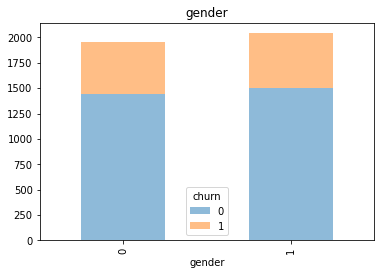

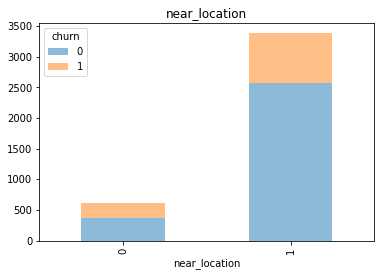

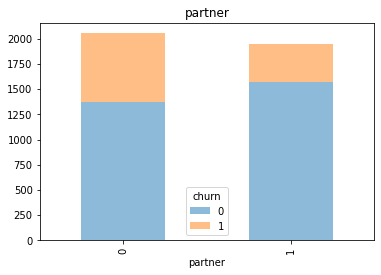

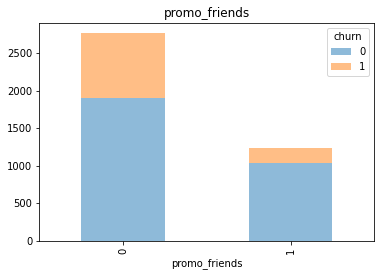

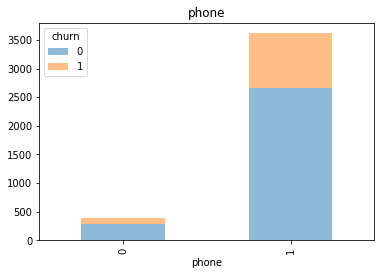

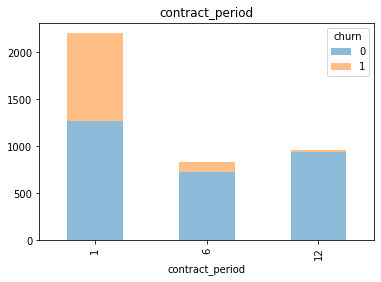

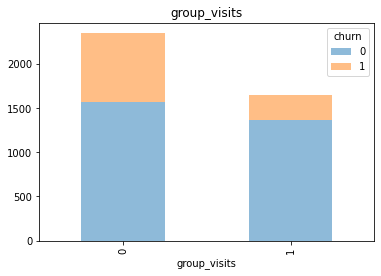

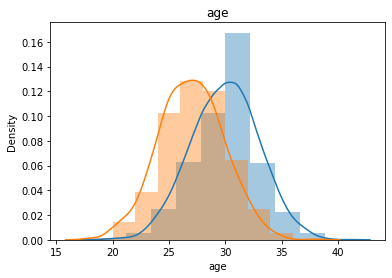

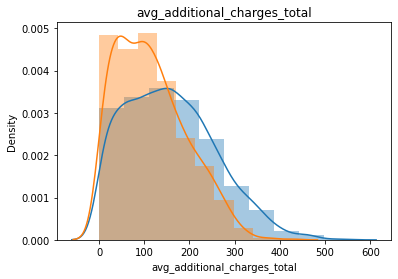

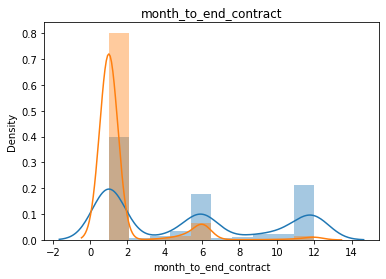

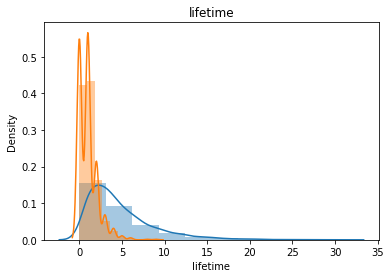

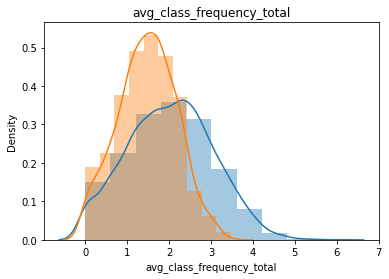

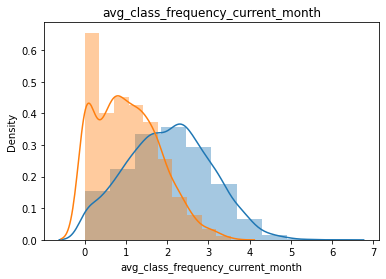

In [9]:
def graphics(data, group_col, name_col):
    data_part = data.copy()[name_col]
    for element_1 in name_col:
        if element_1 == group_col: continue
            
        if len(data_part[element_1].unique()) < 10:
            report = data_part.reset_index().pivot_table(index = element_1,
                                                         columns = group_col,
                                                         values = 'index',
                                                         aggfunc = 'count')
            report.plot(kind='bar',
                        stacked=True,
                        alpha = 0.5
                       )
        else:
            for element_2 in data[group_col].unique():
                sns.distplot(data_part[data_part[group_col] == element_2][element_1],
                             bins=10
                            )
        plt.title(element_1)
        plt.show()
        
graphics(data, 'churn', data.columns);

Из полученных графиков можно сделать следующие выводы:
   - отток женщин и мужчин примерно одинаков (`gender`);
   - отток пользователей живущих поблизости с финтнес-клубом - больше (`near_Location`);
   - сотрудники компании-партнёра клуба бросают занятия с меньшей вероятностью, чем обычные клиенты (`partner`);
   - те, кто не использовал промо-код от знакомого при оформлении абонемента, намного чаще покидают клуб, чем те, кто использовал (`promo_friends`);
   - телефоны указывают практически все клиенты, отток не указавших контактный телефон - минимален (`phone`);
   - пользователи, оформляющие месячный абонемент уходят гораздо чаще, чем оформляющие абонементы на 6 и 12 месяцев, отток клиентов с годовым абонементом - минимален (`contract_period`);
   - посещающие групповые занятия клинты уходят гораздо реже, чем те, кто их не посещает (`group_visits`);
   - средний возраст покидающих клуб меньше, чем тех, кто остается (`age`);
   - чаще остальных уходят те пользователи, которые не тратят на другие услуги фитнес-центра: кафе, спорт-товары, массаж и пр. или тратят их в меньшем количестве (`avg_additional_charges_total`); 
   - очень велика вероятность оттока тех клинтов, у которых остался месяц до истечения срока абонемента (`month_to_end_contract`);
   - если клиент ни разу не обратился в фитнес-центр в течение первых месяцев после оформления, то велика вероятность, что он не вернется (`lifetime`);
   - средний частота посещений фитнеса в неделю за все время с начала действия абонемента для покидающих клуб меньше, чем тех, кто остается, т.е. чем реже клиент ходил заниматься, тем выше вероятность, что он попал в отток (`avg_class_frequency_total`);
   - средняя частота посещений в неделю за предыдущий месяц для покинувших клуб не превышает 4 дней, т.е. те пользователи, которые решили покинуть клуб, скорее всего не приходили ни разу за последний месяц или были 1-2 раза (`avg_class_frequency_total`).

Построю матрицу корреляции:

In [10]:
data.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,month_to_end_contract,lifetime,avg_class_frequency_total,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,-0.001281,0.013579,0.014620,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.143961,0.070921,0.043127,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.294632,0.061229,0.024938,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.239553,0.072721,0.028063,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.011196,-0.018801,0.008340,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.973064,0.170725,0.096211,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.163703,0.075853,0.056695,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.134511,0.164693,0.119953,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.113958,0.079028,0.044426,0.079570,-0.198697
month_to_end_contract,-0.001281,0.143961,0.294632,0.239553,-0.011196,0.973064,0.163703,0.134511,0.113958,1.000000,0.161078,0.085387,0.147605,-0.381393


В результате построение матрицы корреляции выявлены следующие закономерности:

**ни на что не влияют или влияют незначительно следующие признаки**:

    - пол клиента;
    - расположение фитнеса в районе дома (кроме покупки абонемента);
    - указание контактного мобильного телефона;
    - посещение групповых занятий;
    - траты на другие услуги фитнес-центра.
    
**признаки, коррелирующие между собой**:

    - сотрудники компании-партнёра клуба и использующие промо-код от знакомого при оформлении абонемента (k=0.45);
    - срок до окончания текущего действующего абонемента прямо пропорционален длительности текущего действующего абонемента (k=0.97);
    - средняя частота посещений в неделю за предыдущий месяц и за все время с покупки абонемента прямо пропорциональны (k=0.95).

**признаки, влияющие на показатель оттока клиентов из фитнес-клуба**:

    - длительность текущего действующего абонемента (k=-0.4);
    - возраст клиента (k=-0.4);
    - время с момента первого обращения в фитнес-центр (k=-0.44);
    - средняя частота посещений в неделю за предыдущий месяц (k=-0.41).
    

### Выводы по разделу

В результате исследовательского анализа данныз (EDA) сделаны следующие основные выводы:
   
   - мужчин и женщин клиентов фитнес-клуба примерно поровну;
   - проживающих в районе фитнес-клуба - 85%;
   - сотрудников компаний-партнёров клуба и не сотрудников - примерно поровну;
   - использовавших промо-код для покупки певого абонемента - около 30% клентов;
   - контактный телефон оставляют около 90%;
   - групповые занятия посещает около 40%;
   - средний возраст клиентов фитнес-клуба - 29 лет.
   
По параметрам оттока получены следующие результаты:

   - отток женщин и мужчин примерно одинаков;
   - отток пользователей живущих поблизости с финтнес-клубом - больше;
   - сотрудники компании-партнёра клуба бросают занятия с меньшей вероятностью, чем обычные клиенты;
   - те, кто не использовал промо-код от знакомого при оформлении абонемента, намного чаще покидают клуб, чем те, кто использовал;
   - телефоны указывают практически все клиенты, отток не указавших контактный телефон - минимален;
   - пользователи, оформляющие месячный абонемент уходят гораздо чаще, чем оформляющие абонементы на 6 и 12 месяцев, отток клиентов с годовым абонементом - минимален;
   - посещающие групповые занятия клинты уходят гораздо реже, чем те, кто их не посещает;
   - средний возраст покидающих клуб меньше, чем тех, кто остается;
   - чаще остальных уходят те пользователи, которые не тратят на другие услуги фитнес-центра: кафе, спорт-товары, массаж и пр. или тратят их в меньшем количестве; 
   - очень велика вероятность оттока тех клинтов, у которых остался месяц до истечения срока абонемента;
   - если клиент ни разу не обратился в фитнес-центр в течение первых месяцев после оформления, то велика вероятность, что он не вернется;
   - средний частота посещений фитнеса в неделю за все время с начала действия абонемента для покидающих клуб меньше, чем тех, кто остается, т.е. чем реже клиент ходил заниматься, тем выше вероятность, что он попал в отток;
   - средняя частота посещений в неделю за предыдущий месяц для покинувших клуб не превышает 4 дней, т.е. те пользователи, которые решили покинуть клуб, скорее всего не приходили ни разу за последний месяц или были 1-2 раза.
   
Признаки, влияющие на показатель оттока клиентов из фитнес-клуба, следующие (в порядке убывания влияения на показатель):

   - время с момента первого обращения в фитнес-центр;
   - средняя частота посещений в неделю за предыдущий месяц;
   - возраст клиента;
   - длительность текущего действующего абонемента.

## Построение модели прогнозирования оттока пользователей

В данном разделе я буду строить модель бинарной классификации пользователей, где целевой признак — факт оттока пользователя в следующем месяце. 

### Подготовка данных

Для начала необходимо избавиться от мультиколлинеарности в данных. В исследуемом датасете присутствуют признаки, коэффициент корреляции между которыми очень большой (больше 0.8), с регрессией возникнут проблемы, а именно нерепрезентативные веса и переобученная под эти признаки модель. Для исключения факта мультиколлинеарности для каждой пары сильно скоррелированных признаков необходимо удалить один из них:

В исследуемом датасете сильно коррелируют: 
- срок до окончания текущего действующего абонемента `month_to_end_contract` и длительность текущего действующего абонемента `contract_period` (k=0.97);
- средняя частота посещений в неделю за предыдущий месяц `avg_class_frequency_current_month` и за все время с покупки абонемента `avg_class_frequency_total` (k=0.95).

Исключу из каждой пары признаков по одному. В паре `avg_class_frequency_current_month`/`avg_class_frequency_total` исключу столбец средняя частота посещений в неделю за все время с покупки абонемента, т.к. выяснено, что признак **средняя частота посещений в неделю за предыдущий месяц** намного сильнее влияет на показатель оттока клиентов из фитнес-клуба.

In [11]:
# убираю по одному из каждой пары коррелирующих признаков
data.drop(['month_to_end_contract', 'avg_class_frequency_total'], axis=1, inplace=True)
data.corr()

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
gender,1.000000,0.006699,-0.010463,-0.005033,-0.008542,0.000502,0.017879,0.013807,-0.009334,0.013579,0.009156,0.000708
near_location,0.006699,1.000000,-0.005119,0.210964,-0.015763,0.150233,0.154728,0.058358,0.040761,0.070921,0.062664,-0.128098
partner,-0.010463,-0.005119,1.000000,0.451960,0.009970,0.306166,0.022710,0.047480,0.022941,0.061229,0.045561,-0.157986
promo_friends,-0.005033,0.210964,0.451960,1.000000,0.001982,0.244552,0.120170,0.050113,0.036898,0.072721,0.053768,-0.162233
phone,-0.008542,-0.015763,0.009970,0.001982,1.000000,-0.006893,-0.010099,-0.011403,0.009279,-0.018801,0.013375,-0.001177
contract_period,0.000502,0.150233,0.306166,0.244552,-0.006893,1.000000,0.169991,0.138249,0.111445,0.170725,0.159407,-0.389984
group_visits,0.017879,0.154728,0.022710,0.120170,-0.010099,0.169991,1.000000,0.080934,0.032079,0.075853,0.075923,-0.175325
age,0.013807,0.058358,0.047480,0.050113,-0.011403,0.138249,0.080934,1.000000,0.080240,0.164693,0.183095,-0.404735
avg_additional_charges_total,-0.009334,0.040761,0.022941,0.036898,0.009279,0.111445,0.032079,0.080240,1.000000,0.079028,0.079570,-0.198697
lifetime,0.013579,0.070921,0.061229,0.072721,-0.018801,0.170725,0.075853,0.164693,0.079028,1.000000,0.181975,-0.438220


### Создание и стандартизация выборок

Создам датафрейм, соответствующий матрице объект-признак, и вектор (тип Series) целевой переменной `churn`. Разобью данные на обучающую и валидационную выборку функцией train_test_split() в отношении 80% к 20%.

In [14]:
# разделяю данные на признаки (матрица X) и целевую переменную (y)
X = data.drop('churn', axis=1) 
y = data['churn']

# разделяю модель на обучающую и валидационную выборку
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=0, stratify=y)

Диапазоны значений признаков различаются. Веса для разных признаков должны учитывать масштаб этих признаков. Так, у признаков с меньшим масштабом веса должны быть больше, а у остальных — меньше. При этом значения коэффициентов следует подобрать такими, чтобы можно было оценить вклад каждого признака в общую взвешенную сумму. Чтобы веса можно было сравнивать, приведу признаки к единому масштабу. Для этого применю стандартизацию данных.

In [15]:
# создаю объект класса scaler
scaler = StandardScaler()

# обучаю StandartScaler на обучающей выборке
scaler.fit(X_train)

# стандартизирую обучающую выборку методом transform scaler 
X_train_st = scaler.transform(X_train)
# стандартизирую тестовую выборку методом transform scaler
X_test_st = scaler.transform(X_test)

### Обучение моделей и подготовка прогнозов

Обучать модель на train-выборке буду двумя способами:
   - логистической регрессией;
   - случайным лесом.

In [16]:
# задаю алгоритм для модели логистической регрессии
lr_model = LogisticRegression(random_state=0)

# обучаю модель логистической регрессии
lr_model.fit(X_train_st, y_train)

# воспользуюсь обученной моделью, чтобы сделать прогнозы
lr_predictions = lr_model.predict(X_test_st)
lr_probabilities = lr_model.predict_proba(X_test_st)[:, 1]

# задаю алгоритм для модели на основе алгоритма случайного леса
rf_model = RandomForestClassifier(random_state=0)

# обучаю модель случайного леса
rf_model.fit(X_train_st, y_train)

# воспользуюсь обученной моделью, чтобы сделать прогнозы
rf_predictions = rf_model.predict(X_test_st)
rf_probabilities = rf_model.predict_proba(X_test_st)[:, 1]

Опишу функцию вывода метрик `accuracy`, `precision` и `recall` и оценю модели на валидационной выборке. Проведу сравнительный анализ моделей на основе полученных результатов.

In [23]:
# определяю функцию, которая будет выводить необходимые метрики
def print_metrics(y_true, y_pred, y_proba, title):
    print(title)
    print('\tAccuracy: {:.2f}'.format(accuracy_score(y_true, y_pred)))
    print('\tPrecision: {:.2f}'.format(precision_score(y_true, y_pred)))
    print('\tRecall: {:.2f}'.format(recall_score(y_true, y_pred)))
    
print_metrics(
    y_test,
    lr_predictions,
    lr_probabilities,
    title='Метрики для модели логистической регрессии:'
)
print()

print_metrics(
    y_test,
    rf_predictions,
    rf_probabilities,
    title='Метрики для модели случайного леса:'
)

Метрики для модели логистической регрессии:
	Accuracy: 0.92
	Precision: 0.85
	Recall: 0.84

Метрики для модели случайного леса:
	Accuracy: 0.91
	Precision: 0.85
	Recall: 0.77


Проверю соотношение классов:

In [21]:
# соотносятся классов набора данных
print('Соотношение классов:')
print( data['churn'].value_counts())
print()

Соотношение классов:
0    2939
1    1061
Name: churn, dtype: int64



Метрики работают только при условии баланса классов — когда объектов каждого класса примерно поровну, 50%/50%, а в настоящем исследовании отток и оставшиеся клиенты распределены примерно 25%/75%. Классы несбалансированы, т.к. основаны на бинарных ответах, а результат `predict_proba()` уже нельзя интерпретировать как вероятность класса.

Для получения более приемлемых результатов необходимо проверить значения метрик (баланс) при различных значениях порога:

In [22]:
# устанавливаю порог
threshold = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1]

# на основании вероятностей и соотношения классов рассчитаю predict
for element in threshold:
    lr_custom_predictions = [0 if i < element else 1 for i in lr_probabilities]
    rf_custom_predictions = [0 if i < element else 1 for i in rf_probabilities]

    print('\033[1m' + 'Значение метрик при пороговом значении', element, '\033[0m')
    print_metrics(
        y_test,
        lr_custom_predictions,
        lr_probabilities,
        title='Метрики для модели логистической регрессии'
    )
    print()

    print_metrics(
        y_test,
        rf_custom_predictions,
        rf_probabilities,
        title='Метрики для модели случайного леса'
    )
    print()

Значение метрик при пороговом значении 0 
Метрики для модели логистической регрессии
	Accuracy: 0.27
	Precision: 0.27
	Recall: 1.00

Метрики для модели случайного леса
	Accuracy: 0.27
	Precision: 0.27
	Recall: 1.00

Значение метрик при пороговом значении 0.1 
Метрики для модели логистической регрессии
	Accuracy: 0.85
	Precision: 0.65
	Recall: 0.97

Метрики для модели случайного леса
	Accuracy: 0.78
	Precision: 0.55
	Recall: 0.97

Значение метрик при пороговом значении 0.2 
Метрики для модели логистической регрессии
	Accuracy: 0.89
	Precision: 0.72
	Recall: 0.97

Метрики для модели случайного леса
	Accuracy: 0.85
	Precision: 0.66
	Recall: 0.94

Значение метрик при пороговом значении 0.3 
Метрики для модели логистической регрессии
	Accuracy: 0.90
	Precision: 0.76
	Recall: 0.93

Метрики для модели случайного леса
	Accuracy: 0.89
	Precision: 0.74
	Recall: 0.91

Значение метрик при пороговом значении 0.4 
Метрики для модели логистической регрессии
	Accuracy: 0.92
	Precision: 0.81
	Recall: 0

Наиболее оптимальное соотношение метрик достигается при пороге в 0.5 (как и было рассчитано ранее):

Метрики для модели логистической регрессии:

- Доля правильных ответов: 92%
- Точность: 85%
- Полнота: 84%

Метрики для модели случайного леса:

- Доля правильных ответов: 91%
- Точность: 85%
- Полнота: 77%

Сложно однозначно сказать, какая из моделей показала себя лучше на основании полученных метрик, т.к. все значения примерно соизмеримы друг с другом, однако т.к. параметр полноты выше в модели `случайный лес` при равных значениям доли правильных ответов и точности, поэтому буду считать, что модель `случайный лес` показала себя лучше, чем логистическая рагрессия.

### Выводы по разделу

В результате проведенного исследования в данных исключена мультиколлинеарность. Построены модели бинарной классификации клиентов, где целевым признаком является факт оттока клиента в следующем месяце. Данные разбиты на обучающую и валидационную выборки, стандартизованы.

Выбраны 2 модели машинного обучения для построения прогрноза оттка пользователей:

- логистическая регрессия;
- случайный лес.

Модель `случайные лес` показала себя лучше на основании полученных значений исследуемых метрик.

## Кластеризация пользователей

В данном разделе буду проводить кластеризацию пользователей с учётом имеющихся в датафреме признаков, а именно, выделять несколько наиболее ярких групп и характеризовать их основные свойства для анализа основных признаков, наиболее сильно влияющих на отток в данных группах. 

### Стандартизация и построение дендрограммы

Для начала проведу обязательную стандартизацию данных перед работой с алгоритмами. Построю матрицу расстояний функцией `linkage()` на стандартизованной матрице признаков и нарисую дендрограмму. 

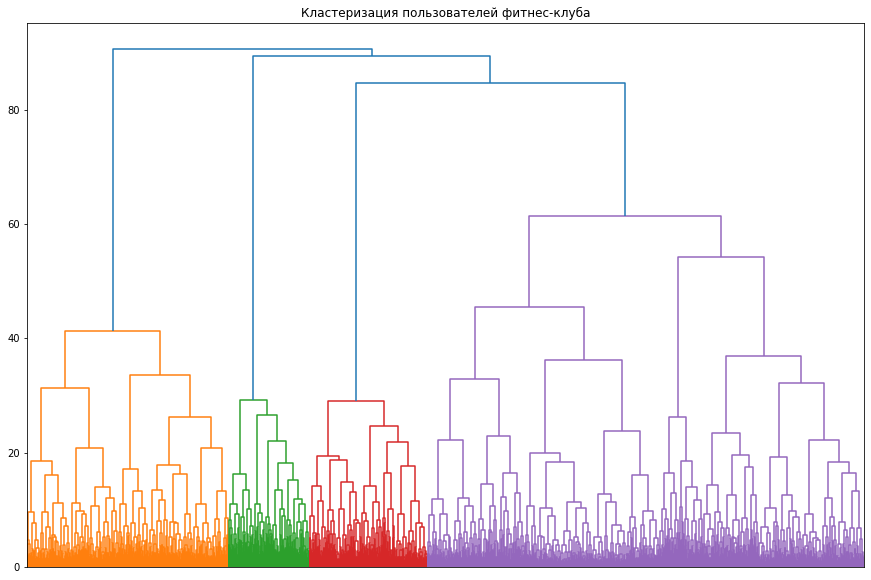

In [17]:
# обязательная стандартизация данных перед работой с алгоритмами
sc = StandardScaler()
X_sc = sc.fit_transform(X)

linked = linkage(X_sc, method = 'ward') 

# визуализмрую
plt.figure(figsize=(15, 10))  
dendrogram(linked, orientation='top')
plt.title('Кластеризация пользователей фитнес-клуба')
plt.xticks([])
plt.show() 

Предложенное оптимальное число кластеров 4 — четыре разных цвета на дендрограмме, однако визуально пятый кластер по-крупному бьётся еще на 2, поэтому для увеличения точности будущих прогнозов приму **K=5**.

### Обучение модели кластеризации

In [18]:
# задаю число кластеров, равное 5, и фиксирую значение random_state для воспроизводимости результата
km = KMeans(n_clusters=5, random_state=0)

# применяю алгоритм к данным и формирую вектор кластеров 
labels = km.fit_predict(X_sc) 
data['labels'] = labels
data.value_counts('labels').sort_values(ascending=False)

labels
2    1064
3    1007
0     985
1     558
4     386
dtype: int64

### Расчеты в кластерах

Рассчитаю средние значения признаков для каждого из кластеров:

In [19]:
# вывожу статистику по средним значениям признаков по кластеру
data.groupby('labels').agg('mean')

,gender,near_location,partner,promo_friends,phone,contract_period,group_visits,age,avg_additional_charges_total,lifetime,avg_class_frequency_current_month,churn
labels,,,,,,,,,,,,
0,0.496447,0.995939,0.892386,1.000000,1.0,6.922843,0.524873,29.606091,153.424651,4.283249,1.919520,0.119797
1,0.500000,0.000000,0.489247,0.078853,1.0,2.994624,0.232975,28.679211,137.125763,2.974910,1.597146,0.403226
2,0.500940,1.000000,0.217105,0.072368,1.0,2.010338,0.277256,27.583647,119.339956,1.922932,1.203319,0.563910
3,0.534260,0.996028,0.379345,0.009930,1.0,6.208540,0.538232,30.699106,176.259567,5.415094,2.324220,0.014896
4,0.523316,0.862694,0.471503,0.305699,0.0,4.777202,0.427461,29.297927,144.208179,3.940415,1.723967,0.266839


По полученным значениям можно заметить следующее:

- группа пользователей, не проживающих в районе фитнес-клуба,
- группа пользователей с преобладанием в ней сотрудников компаний-партнёров клуба,
- группа пользователей, в которой использован промо-код от знакомого при оплате первого абонемента

имеют характерные особенности, отличные от других пользователей.

Также можно увидеть, что в двух группах, в которых происходит больше всего оттока пользователей (среднее значения `churn` равно 0.4 и 0,56):
- самое маленькое значение среднего возраста;
- самое короткое среднее время с момента первого обращения в фитнес-центр;
- самое маленькое значение средней частоты посещений в неделю за предыдущий месяц; 
- самый маленький показатель средней суммарной выручки от других услуг фитнес-центра;
- минимальное посещение групповых занятый;
- самое маленькое значение средней длительности абонемента.

Построю графики распределения признаков для полученных кластеров. Для дискретных переменных буду использовать столбцовые графики с накоплением, а для непрерывных переменных - гистограммы с применением ранее написанной функции `graphics`.

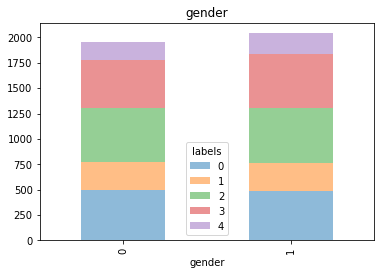

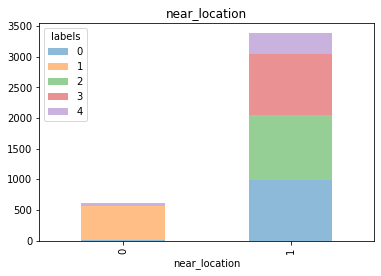

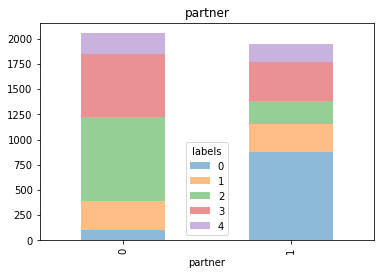

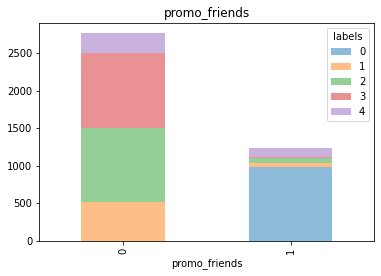

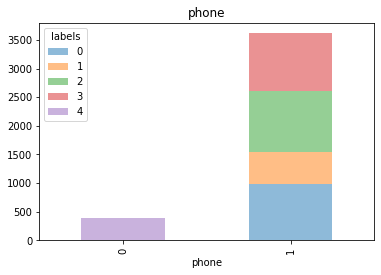

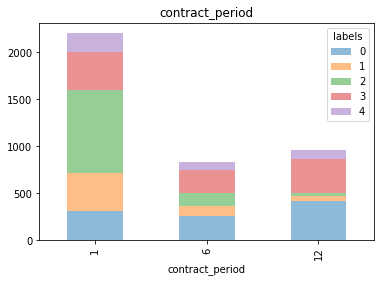

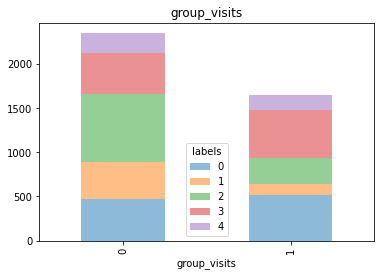

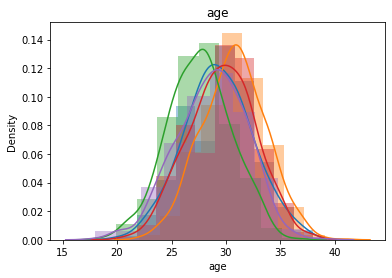

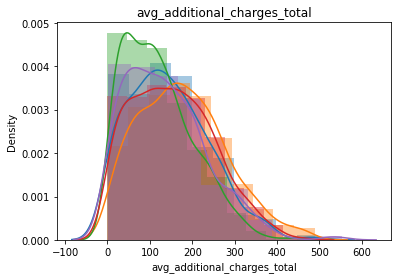

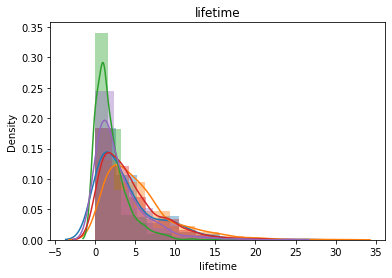

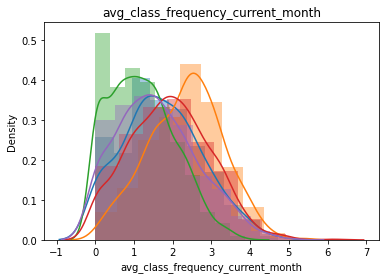

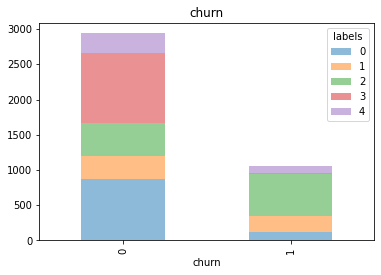

In [20]:
graphics(data, 'labels', data.columns)

По полученным графикам распределений можно заметить:
- абсолютно отсутствует отток тех клиентов, которые часто посещают клуб (более 2 раз в неделю), у которых фитнес находится рядом с домом;
- высокий отток характерен для клиентов помладше;
- высокий отток также характерен для пользователей кто мало тратит или не тратит вовсе деньги на другие услиги фитнес-клуба: кафе, спорт-товары, косметический и массажный салон.

Для каждого полученного кластера посчитаю долю оттока:

In [21]:
#data.query('churn == 1').groupby('labels')['churn'].count() / data.groupby('labels')['churn'].count()
print(data.groupby('labels')['churn'].mean())

labels
0    0.119797
1    0.403226
2    0.563910
3    0.014896
4    0.266839
Name: churn, dtype: float64


Проанализировав получившиеся значения, можно сказать о том, что **группа 3 наиболее надёжна**. Процент оттока клиентов в данной группе менее 1,5%, тогда как **группы 2 и 1 склонны к оттоку** клиентов, в них процент отказа от услуг фитнес-центра равен 56,4% и 40,3% соответственно. Также можно сказать, что **из группы 0 также уходит небольшое количество клиентов**, всего 12%, а **группу 4 покидает меньше трети клиентов**.

Для определения основных признаков, наиболее сильно влияющие на отток пользователей, необходимо обратиться к таблице средних значений признаков для каждого из кластеров. Проанализировать необходимо те кластеры, в которых наблюдается минимальный и максимальный отток пользователей, а именно кластеры №3, 2 и 1.

### Выводы по разделу

Данные разбиты на 5 кластеров. 

По полученным средним значениям признаков для каждого из кластеров можно заметить, что в группах, где происходит больше всего оттока пользователей:
- самое маленькое значение среднего возраста;
- самое короткое среднее время с момента первого обращения в фитнес-центр;
- самое маленькое значение средней частоты посещений в неделю за предыдущий месяц;
- самый маленький показатель средней суммарной выручки от других услуг фитнес-центра;
- минимальное посещение групповых занятый;
- самое маленькое значение средней длительности абонемента.

## Выводы и рекомендации

### Выводы

Проведенное исследование показало:

- отток женщин и мужчин примерно одинаков;
- сотрудники компании-партнёра клуба бросают занятия с меньшей вероятностью, чем обычные клиенты;
- те, кто не использовал промо-код от знакомого при оформлении абонемента, намного чаще покидают клуб, чем те, кто использовал;
- телефоны указывают практически все клиенты, отток не указавших контактный телефон - минимален;
- пользователи, оформляющие месячный абонемент уходят гораздо чаще, чем оформляющие абонементы на 6 и 12 месяцев, отток клиентов с годовым абонементом - минимален;
- посещающие групповые занятия клинты уходят гораздо реже, чем те, кто их не посещает;
- средний возраст покидающих клуб меньше, чем тех, кто остается;
- чаще остальных уходят те пользователи, которые не тратят на другие услуги фитнес-центра: кафе, спорт-товары, массаж и пр. или тратят их в меньшем количестве;
- очень велика вероятность оттока тех клинтов, у которых остался месяц и меньше до истечения срока абонемента;
- если клиент ни разу не обратился в фитнес-центр в течение первых месяцев после оформления, то велика вероятность, что он не вернется;
- средняя частота посещений фитнеса в неделю за все время с начала действия абонемента для покидающих клуб меньше, чем тех, кто остается, т.е. чем реже клиент ходил заниматься, тем выше вероятность, что он попал в отток;
- средняя частота посещений в неделю за предыдущий месяц для покинувших клуб не превышает 4 дней, т.е. те пользователи, которые решили покинуть клуб, скорее всего не приходили ни разу за последний месяц или были 1-2 раза.

Признаки, влияющие на показатель оттока клиентов из фитнес-клуба, следующие (в порядке убывания влияения на показатель):

- время с момента первого обращения в фитнес-центр;
- средняя частота посещений в неделю за предыдущий месяц;
- возраст клиента;
- длительность текущего действующего абонемента.

Определено:    

- абсолютно отсутствует отток тех клиентов, которые часто посещают клуб (более 2 раз в неделю), у которых фитнес находится рядом с домом;
- высокий отток характерен для клиентов помладше;
- высокий отток также характерен для пользователей кто мало тратит или не тратит вовсе деньги на другие услиги фитнес-клуба: кафе, спорт-товары, косметический и массажный салон.

Для группы с минимальным оттоком клентов характерны слудующие признаки:

- НЕ использован промо-код от знакомого при оплате первого абонемента;
- покупка 6-месячного абонемента;
- частое посещение групповых занятий;
- посещение фитнеса в среднем 2-3 раза в неделю;
- среднее время с момента первого обращения в фитнес-центр - около 5 месяцев;
- высокий уровень трат на другие услуги фитнес-центра.

Для групп с максимальным оттоком характерно:

- низкий уровень трат на другие услуги фитнес-центра;
- среднее время с момента первого обращения в фитнес-центр - около 2-3 месяцев;
- редкое посещение групповых занятий;
- покупка абонемента на 1 месяц.

### Рекомендации

Исходя из проделанной работы, можно сформулировать основные базовые рекомендации для стратегии взаимодействия с клиентами для уменьшения их оттока из фитнес-центра:
- вести активные кампании по привлечению пользователей на групповые занятия клуба;
- делать хорошие скидки на полугодовые абонементы;
- осуществлять поощрения тех пользователей (скидки, подарки), которые посещвют фитнес клуб 2 и более раз в месяц
- делать масштабные рекламные кампании в районе нахождения фитнес-центра.